In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch

import pickle

In [4]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

In [5]:
device = torch.device("cuda")

In [ ]:
#from utils.model import LaplaceBayesianCNNSingleFCCustom

In [ ]:
class LaplaceBayesianCNNSingleFC(PyroModule):
    def __init__(self, num_classes, device):
        super().__init__()

        prior_mu = 0.
        prior_b = torch.tensor(1., device=device)

        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Laplace(prior_mu, prior_b).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Laplace(prior_mu, prior_b).expand([32]).to_event(1))

        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = PyroSample(dist.Laplace(prior_mu, prior_b).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Laplace(prior_mu, prior_b).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global average pooling to reduce [B, 64, 16, 16] → [B, 64]
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer: 64 → num_classes
        self.fc1 = PyroModule[nn.Linear](64, num_classes)
        self.fc1.weight = PyroSample(dist.Laplace(prior_mu, prior_b).expand([num_classes, 64]).to_event(2))
        self.fc1.bias = PyroSample(dist.Laplace(prior_mu, prior_b).expand([num_classes]).to_event(1))

    def forward(self, x, y=None):
        # x: [B, 3, 64, 64]
        x = self.pool(F.relu(self.conv1(x)))  # → [B, 32, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # → [B, 64, 16, 16]
        x = self.gap(x)                       # → [B, 64, 1, 1]
        x = x.view(x.size(0), -1)             # → [B, 64]
        logits = self.fc1(x)                  # → [B, num_classes]

        if y is not None:
            with pyro.plate("data", x.size(0)):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)

        return logits

In [ ]:
class BayesianCNNSingleFC(PyroModule):
    def __init__(self, num_classes, mu, sigma, device):
        super().__init__()

        prior_mu = 0.
        prior_b = torch.tensor(10., device=device)

        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Normal(prior_mu, prior_b).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(prior_mu, prior_b).expand([32]).to_event(1))

        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = PyroSample(dist.Normal(prior_mu, prior_b).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(prior_mu, prior_b).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global average pooling to reduce [B, 64, 16, 16] → [B, 64]
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer: 64 → num_classes
        self.fc1 = PyroModule[nn.Linear](64, num_classes)
        self.fc1.weight = PyroSample(dist.Normal(prior_mu, prior_b).expand([num_classes, 64]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(prior_mu, prior_b).expand([num_classes]).to_event(1))

    def forward(self, x, y=None):
        # x: [B, 3, 64, 64]
        x = self.pool(F.relu(self.conv1(x)))  # → [B, 32, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # → [B, 64, 16, 16]
        x = self.gap(x)                       # → [B, 64, 1, 1]
        x = x.view(x.size(0), -1)             # → [B, 64]
        logits = self.fc1(x)                  # → [B, num_classes]

        if y is not None:
            with pyro.plate("data", x.size(0)):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)

        return logits

In [ ]:
"""
class BayesianCNNSingleFC(PyroModule):
    def __init__(self, num_classes, device):
        super().__init__()

        prior_mu = 0.
        prior_b = torch.tensor(10., device=device)

        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Normal(prior_mu, prior_b).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(prior_mu, prior_b).expand([32]).to_event(1))

        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = PyroSample(dist.Normal(prior_mu, prior_b).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(prior_mu, prior_b).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Change: Output shape will be [B, 64, 2, 2] after GAP
        self.gap = nn.AdaptiveAvgPool2d((2, 2))

        # Flattened output size: 64 channels × 2 × 2 = 256
        self.fc1 = PyroModule[nn.Linear](256, num_classes)
        self.fc1.weight = PyroSample(dist.Normal(prior_mu, prior_b).expand([num_classes, 256]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(prior_mu, prior_b).expand([num_classes]).to_event(1))

    def forward(self, x, y=None):
        # Input: [B, 3, 64, 64]
        x = self.pool(F.relu(self.conv1(x)))  # → [B, 32, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # → [B, 64, 16, 16]
        x = self.gap(x)                       # → [B, 64, 2, 2]
        x = x.view(x.size(0), -1)             # → [B, 256]
        logits = self.fc1(x)                  # → [B, num_classes]

        if y is not None:
            with pyro.plate("data", x.size(0)):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)

        return logits
"""

In [4]:
import pkg_resources
print(pkg_resources.get_distribution("requests").version)

2.32.3


In [7]:
def load_data(batch_size=54):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3803, 0.4078], 
                             std=[0.0914, 0.0651, 0.0552])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=True)

    torch.manual_seed(42)

    #train_size = int(0.8 * len(dataset))
    #test_size = len(dataset) - train_size
    #train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    # Add num_workers and pin_memory for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [8]:
num_classes = 10
#bayesian_model = LaplaceBayesianCNNSingleFCCustom(num_classes=num_classes, 
#                                                  device=device,
#                                                  mu=0., b=10.)
bayesian_model = BayesianCNNSingleFC(num_classes=num_classes, device=device)

In [9]:
from pyro.infer.autoguide import AutoDiagonalNormal
#from pyro.infer.autoguide import AutoLowRankMultivariateNormal
from pyro.optim import Adam

In [10]:
guide = AutoDiagonalNormal(bayesian_model)
#guide = AutoLowRankMultivariateNormal(bayesian_model, rank=20)

# 2. Optimizer and SVI - increase learning rate for better convergence
optimizer = Adam({"lr": 1e-3})  # Increased from 1e-4 to 1e-3
svi = pyro.infer.SVI(model=bayesian_model,
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO(num_particles=1,
                                                )) #TODO

In [11]:
from tqdm import tqdm

In [ ]:
def train_svi(model, guide, svi, train_loader, num_epochs=10):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    #guide.to(device)
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")

In [ ]:
def train_svi(model, guide, svi, train_loader, num_epochs=10):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    #guide.to(device)
    
    # Lists to store losses and accuracies
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            model.train()  # Set back to training mode
            
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    return epoch_losses, epoch_accuracies, accuracy_epochs

In [ ]:
def train_svi_with_annealing(model, guide, svi, train_loader, num_epochs=10):
    pyro.clear_param_store()
    model.train()
    model.to(device)
    
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    for epoch in range(num_epochs):
        # KL annealing - gradually increase KL weight
        kl_weight = min(1.0, (epoch + 1) / (num_epochs * 0.5))  # Reach full weight at 50% of training
        
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            # Use weighted ELBO
            def weighted_model(images, labels):
                with pyro.poutine.scale(scale=kl_weight):
                    return model(images, labels)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)

        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            model.train()  # Set back to training mode
            
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    return epoch_losses, epoch_accuracies, accuracy_epochs

In [12]:
def train_svi_with_stats(model, guide, svi, train_loader, num_epochs=10):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    
    # Lists to store losses and accuracies
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    # Lists to store weight and bias statistics
    weight_stats = {'epochs': [], 'means': [], 'stds': []}
    bias_stats = {'epochs': [], 'means': [], 'stds': []}
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            # Record weight and bias statistics
            weight_means = []
            weight_stds = []
            bias_means = []
            bias_stds = []
            
            for name, param in pyro.get_param_store().items():
                if 'AutoDiagonalNormal.loc' in name:
                    weight_means.append(param.mean().item())
                    weight_stds.append(param.std().item())
                elif 'AutoDiagonalNormal.scale' in name:
                    bias_means.append(param.mean().item())
                    bias_stds.append(param.std().item())
            
            # Store statistics for this epoch
            weight_stats['epochs'].append(epoch + 1)
            weight_stats['means'].append(weight_means)
            weight_stats['stds'].append(weight_stds)
            
            bias_stats['epochs'].append(epoch + 1)
            bias_stats['means'].append(bias_means)
            bias_stats['stds'].append(bias_stds)
            
            model.train()  # Set back to training mode
            
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    return epoch_losses, epoch_accuracies, accuracy_epochs, weight_stats, bias_stats

def plot_training_results_with_stats(losses, accuracies, accuracy_epochs, weight_stats, bias_stats):
    """Plot training results with weight and bias statistics"""
    plt.figure(figsize=(16, 12))
    
    # Plot 1: Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(losses) + 1), losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO Loss')
    plt.grid(True)
    
    # Plot 2: Training Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(accuracy_epochs, accuracies, 'o-')
    plt.title('Training Accuracy (Every 10 Epochs)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    
    # Plot 3: Weight Statistics Boxplot
    plt.subplot(2, 2, 3)
    weight_data = []
    weight_labels = []
    
    for i, epoch in enumerate(weight_stats['epochs']):
        # Combine means and stds for this epoch
        epoch_data = weight_stats['means'][i] + weight_stats['stds'][i]
        weight_data.append(epoch_data)
        weight_labels.append(f'Epoch {epoch}')
    
    if weight_data:
        bp1 = plt.boxplot(weight_data, labels=weight_labels, patch_artist=True)
        for patch in bp1['boxes']:
            patch.set_facecolor('lightblue')
    
    plt.title('LOC Statistics Distribution')
    plt.xlabel('Epoch')
    plt.ylabel('LOC Values')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Bias Statistics Boxplot
    plt.subplot(2, 2, 4)
    bias_data = []
    bias_labels = []
    
    for i, epoch in enumerate(bias_stats['epochs']):
        # Combine means and stds for this epoch
        epoch_data = bias_stats['means'][i] + bias_stats['stds'][i]
        bias_data.append(epoch_data)
        bias_labels.append(f'Epoch {epoch}')
    
    if bias_data:
        bp2 = plt.boxplot(bias_data, tick_labels=bias_labels, patch_artist=True)
        for patch in bp2['boxes']:
            patch.set_facecolor('lightcoral')
    
    plt.title('SCALE Statistics Distribution')
    plt.xlabel('Epoch')
    plt.ylabel('SCALE Values')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [13]:
pyro.clear_param_store()

# Ensure model and guide are on the correct device
bayesian_model.to(device)
guide.to(device)

train_loader, test_loader = load_data(batch_size=54)

# Train with statistics recording
losses, accuracies, accuracy_epochs, weight_stats, bias_stats = train_svi_with_stats(
    bayesian_model, guide, svi, train_loader, num_epochs=200 #TODO
)

Calculating accuracy for epoch 1: 100%|██████████| 400/400 [00:05<00:00, 76.02it/s]


Epoch 1 - ELBO Loss: 1461417.1548, Train Accuracy: 38.83%


Epoch 2/200: 100%|██████████| 400/400 [00:09<00:00, 43.18it/s]


Epoch 2 - ELBO Loss: 447365.5846


Epoch 3/200: 100%|██████████| 400/400 [00:08<00:00, 47.40it/s]


Epoch 3 - ELBO Loss: 388383.9629


Epoch 4/200: 100%|██████████| 400/400 [00:08<00:00, 47.81it/s]


Epoch 4 - ELBO Loss: 360533.5841


Epoch 5/200: 100%|██████████| 400/400 [00:08<00:00, 47.96it/s]


Epoch 5 - ELBO Loss: 348470.4993


Epoch 6/200: 100%|██████████| 400/400 [00:08<00:00, 47.55it/s]


Epoch 6 - ELBO Loss: 336525.1576


Epoch 7/200: 100%|██████████| 400/400 [00:08<00:00, 47.33it/s]


Epoch 7 - ELBO Loss: 327892.4328


Epoch 8/200: 100%|██████████| 400/400 [00:08<00:00, 48.03it/s]


Epoch 8 - ELBO Loss: 318408.8204


Epoch 9/200: 100%|██████████| 400/400 [00:08<00:00, 47.10it/s]


Epoch 9 - ELBO Loss: 311491.8137


Calculating accuracy for epoch 10: 100%|██████████| 400/400 [00:04<00:00, 81.45it/s]


Epoch 10 - ELBO Loss: 306988.8828, Train Accuracy: 59.73%


Epoch 11/200: 100%|██████████| 400/400 [00:08<00:00, 47.55it/s]


Epoch 11 - ELBO Loss: 300121.0425


Epoch 12/200: 100%|██████████| 400/400 [00:08<00:00, 47.21it/s]


Epoch 12 - ELBO Loss: 295266.6703


Epoch 13/200: 100%|██████████| 400/400 [00:08<00:00, 47.50it/s]


Epoch 13 - ELBO Loss: 291896.0035


Epoch 14/200: 100%|██████████| 400/400 [00:08<00:00, 47.11it/s]


Epoch 14 - ELBO Loss: 286621.2182


Epoch 15/200: 100%|██████████| 400/400 [00:08<00:00, 48.04it/s]


Epoch 15 - ELBO Loss: 280308.5305


Epoch 16/200: 100%|██████████| 400/400 [00:08<00:00, 47.46it/s]


Epoch 16 - ELBO Loss: 278947.3342


Epoch 17/200: 100%|██████████| 400/400 [00:08<00:00, 47.26it/s]


Epoch 17 - ELBO Loss: 274656.0957


Epoch 18/200: 100%|██████████| 400/400 [00:08<00:00, 47.54it/s]


Epoch 18 - ELBO Loss: 270153.6993


Epoch 19/200: 100%|██████████| 400/400 [00:08<00:00, 47.43it/s]


Epoch 19 - ELBO Loss: 268119.6620


Calculating accuracy for epoch 20: 100%|██████████| 400/400 [00:04<00:00, 80.00it/s]


Epoch 20 - ELBO Loss: 264287.6610, Train Accuracy: 65.85%


Epoch 21/200: 100%|██████████| 400/400 [00:08<00:00, 47.30it/s]


Epoch 21 - ELBO Loss: 262898.0823


Epoch 22/200: 100%|██████████| 400/400 [00:08<00:00, 47.64it/s]


Epoch 22 - ELBO Loss: 260179.3993


Epoch 23/200: 100%|██████████| 400/400 [00:08<00:00, 47.18it/s]


Epoch 23 - ELBO Loss: 258513.7405


Epoch 24/200: 100%|██████████| 400/400 [00:08<00:00, 47.37it/s]


Epoch 24 - ELBO Loss: 254992.1722


Epoch 25/200: 100%|██████████| 400/400 [00:08<00:00, 47.23it/s]


Epoch 25 - ELBO Loss: 253167.7891


Epoch 26/200: 100%|██████████| 400/400 [00:08<00:00, 47.61it/s]


Epoch 26 - ELBO Loss: 251116.7623


Epoch 27/200: 100%|██████████| 400/400 [00:08<00:00, 47.87it/s]


Epoch 27 - ELBO Loss: 247282.2598


Epoch 28/200: 100%|██████████| 400/400 [00:08<00:00, 48.06it/s]


Epoch 28 - ELBO Loss: 245715.5276


Epoch 29/200: 100%|██████████| 400/400 [00:08<00:00, 47.53it/s]


Epoch 29 - ELBO Loss: 243588.3838


Calculating accuracy for epoch 30: 100%|██████████| 400/400 [00:04<00:00, 81.92it/s]


Epoch 30 - ELBO Loss: 240858.4029, Train Accuracy: 69.71%


Epoch 31/200: 100%|██████████| 400/400 [00:08<00:00, 48.29it/s]


Epoch 31 - ELBO Loss: 239709.6077


Epoch 32/200: 100%|██████████| 400/400 [00:08<00:00, 47.78it/s]


Epoch 32 - ELBO Loss: 236245.0503


Epoch 33/200: 100%|██████████| 400/400 [00:08<00:00, 47.37it/s]


Epoch 33 - ELBO Loss: 236237.7115


Epoch 34/200: 100%|██████████| 400/400 [00:08<00:00, 47.30it/s]


Epoch 34 - ELBO Loss: 234231.3750


Epoch 35/200: 100%|██████████| 400/400 [00:08<00:00, 46.93it/s]


Epoch 35 - ELBO Loss: 232599.6689


Epoch 36/200: 100%|██████████| 400/400 [00:08<00:00, 47.06it/s]


Epoch 36 - ELBO Loss: 231081.9317


Epoch 37/200: 100%|██████████| 400/400 [00:08<00:00, 47.65it/s]


Epoch 37 - ELBO Loss: 229714.2481


Epoch 38/200: 100%|██████████| 400/400 [00:08<00:00, 47.68it/s]


Epoch 38 - ELBO Loss: 227086.5435


Epoch 39/200: 100%|██████████| 400/400 [00:08<00:00, 47.84it/s]


Epoch 39 - ELBO Loss: 226087.1730


Calculating accuracy for epoch 40: 100%|██████████| 400/400 [00:04<00:00, 80.12it/s]


Epoch 40 - ELBO Loss: 225134.6373, Train Accuracy: 72.10%


Epoch 41/200: 100%|██████████| 400/400 [00:08<00:00, 47.71it/s]


Epoch 41 - ELBO Loss: 223454.1390


Epoch 42/200: 100%|██████████| 400/400 [00:08<00:00, 47.10it/s]


Epoch 42 - ELBO Loss: 222181.6509


Epoch 43/200: 100%|██████████| 400/400 [00:08<00:00, 46.91it/s]


Epoch 43 - ELBO Loss: 220476.7648


Epoch 44/200: 100%|██████████| 400/400 [00:08<00:00, 47.14it/s]


Epoch 44 - ELBO Loss: 219554.9789


Epoch 45/200: 100%|██████████| 400/400 [00:08<00:00, 46.90it/s]


Epoch 45 - ELBO Loss: 218430.0459


Epoch 46/200: 100%|██████████| 400/400 [00:08<00:00, 47.49it/s]


Epoch 46 - ELBO Loss: 216876.2238


Epoch 47/200: 100%|██████████| 400/400 [00:08<00:00, 47.19it/s]


Epoch 47 - ELBO Loss: 215460.4329


Epoch 48/200: 100%|██████████| 400/400 [00:08<00:00, 46.95it/s]


Epoch 48 - ELBO Loss: 214456.0548


Epoch 49/200: 100%|██████████| 400/400 [00:08<00:00, 47.13it/s]


Epoch 49 - ELBO Loss: 213460.1553


Calculating accuracy for epoch 50: 100%|██████████| 400/400 [00:04<00:00, 80.87it/s]


Epoch 50 - ELBO Loss: 212630.4479, Train Accuracy: 74.25%


Epoch 51/200: 100%|██████████| 400/400 [00:08<00:00, 46.16it/s]


Epoch 51 - ELBO Loss: 211736.5098


Epoch 52/200: 100%|██████████| 400/400 [00:08<00:00, 47.91it/s]


Epoch 52 - ELBO Loss: 209814.1851


Epoch 53/200: 100%|██████████| 400/400 [00:08<00:00, 45.63it/s]


Epoch 53 - ELBO Loss: 209808.5960


Epoch 54/200: 100%|██████████| 400/400 [00:08<00:00, 46.72it/s]


Epoch 54 - ELBO Loss: 207877.5086


Epoch 55/200: 100%|██████████| 400/400 [00:08<00:00, 48.09it/s]


Epoch 55 - ELBO Loss: 206672.7209


Epoch 56/200: 100%|██████████| 400/400 [00:08<00:00, 47.49it/s]


Epoch 56 - ELBO Loss: 205540.8991


Epoch 57/200: 100%|██████████| 400/400 [00:08<00:00, 47.41it/s]


Epoch 57 - ELBO Loss: 205339.9312


Epoch 58/200: 100%|██████████| 400/400 [00:08<00:00, 46.93it/s]


Epoch 58 - ELBO Loss: 202818.3311


Epoch 59/200: 100%|██████████| 400/400 [00:08<00:00, 47.31it/s]


Epoch 59 - ELBO Loss: 202372.2997


Calculating accuracy for epoch 60: 100%|██████████| 400/400 [00:04<00:00, 81.66it/s]


Epoch 60 - ELBO Loss: 201256.6099, Train Accuracy: 74.05%


Epoch 61/200: 100%|██████████| 400/400 [00:08<00:00, 47.32it/s]


Epoch 61 - ELBO Loss: 200305.5315


Epoch 62/200: 100%|██████████| 400/400 [00:08<00:00, 47.06it/s]


Epoch 62 - ELBO Loss: 199284.4879


Epoch 63/200: 100%|██████████| 400/400 [00:08<00:00, 47.17it/s]


Epoch 63 - ELBO Loss: 198686.0064


Epoch 64/200: 100%|██████████| 400/400 [00:08<00:00, 46.64it/s]


Epoch 64 - ELBO Loss: 196671.4696


Epoch 65/200: 100%|██████████| 400/400 [00:08<00:00, 46.60it/s]


Epoch 65 - ELBO Loss: 196567.9561


Epoch 66/200: 100%|██████████| 400/400 [00:08<00:00, 46.85it/s]


Epoch 66 - ELBO Loss: 194748.9432


Epoch 67/200: 100%|██████████| 400/400 [00:08<00:00, 46.80it/s]


Epoch 67 - ELBO Loss: 194429.9454


Epoch 68/200: 100%|██████████| 400/400 [00:08<00:00, 46.86it/s]


Epoch 68 - ELBO Loss: 193207.4871


Epoch 69/200: 100%|██████████| 400/400 [00:08<00:00, 47.68it/s]


Epoch 69 - ELBO Loss: 191697.0740


Calculating accuracy for epoch 70: 100%|██████████| 400/400 [00:04<00:00, 81.48it/s]


Epoch 70 - ELBO Loss: 191224.6222, Train Accuracy: 76.94%


Epoch 71/200: 100%|██████████| 400/400 [00:08<00:00, 47.09it/s]


Epoch 71 - ELBO Loss: 190715.4561


Epoch 72/200: 100%|██████████| 400/400 [00:08<00:00, 47.35it/s]


Epoch 72 - ELBO Loss: 189351.9078


Epoch 73/200: 100%|██████████| 400/400 [00:08<00:00, 47.03it/s]


Epoch 73 - ELBO Loss: 188345.7019


Epoch 74/200: 100%|██████████| 400/400 [00:08<00:00, 47.70it/s]


Epoch 74 - ELBO Loss: 187628.9922


Epoch 75/200: 100%|██████████| 400/400 [00:08<00:00, 47.18it/s]


Epoch 75 - ELBO Loss: 186732.6780


Epoch 76/200: 100%|██████████| 400/400 [00:08<00:00, 47.77it/s]


Epoch 76 - ELBO Loss: 185401.0182


Epoch 77/200: 100%|██████████| 400/400 [00:08<00:00, 47.43it/s]


Epoch 77 - ELBO Loss: 184188.5751


Epoch 78/200: 100%|██████████| 400/400 [00:08<00:00, 47.68it/s]


Epoch 78 - ELBO Loss: 183503.3776


Epoch 79/200: 100%|██████████| 400/400 [00:08<00:00, 47.82it/s]


Epoch 79 - ELBO Loss: 182615.3536


Calculating accuracy for epoch 80: 100%|██████████| 400/400 [00:04<00:00, 81.54it/s]


Epoch 80 - ELBO Loss: 181583.3415, Train Accuracy: 77.53%


Epoch 81/200: 100%|██████████| 400/400 [00:08<00:00, 47.78it/s]


Epoch 81 - ELBO Loss: 180601.5822


Epoch 82/200: 100%|██████████| 400/400 [00:08<00:00, 47.31it/s]


Epoch 82 - ELBO Loss: 179791.1476


Epoch 83/200: 100%|██████████| 400/400 [00:08<00:00, 47.80it/s]


Epoch 83 - ELBO Loss: 178559.4797


Epoch 84/200: 100%|██████████| 400/400 [00:08<00:00, 47.36it/s]


Epoch 84 - ELBO Loss: 177751.1999


Epoch 85/200: 100%|██████████| 400/400 [00:08<00:00, 47.49it/s]


Epoch 85 - ELBO Loss: 176348.9497


Epoch 86/200: 100%|██████████| 400/400 [00:08<00:00, 48.03it/s]


Epoch 86 - ELBO Loss: 175594.4881


Epoch 87/200: 100%|██████████| 400/400 [00:08<00:00, 47.67it/s]


Epoch 87 - ELBO Loss: 174270.9538


Epoch 88/200: 100%|██████████| 400/400 [00:08<00:00, 47.53it/s]


Epoch 88 - ELBO Loss: 173355.0269


Epoch 89/200: 100%|██████████| 400/400 [00:08<00:00, 46.98it/s]


Epoch 89 - ELBO Loss: 172758.2423


Calculating accuracy for epoch 90: 100%|██████████| 400/400 [00:04<00:00, 81.07it/s]


Epoch 90 - ELBO Loss: 172072.6168, Train Accuracy: 76.79%


Epoch 91/200: 100%|██████████| 400/400 [00:08<00:00, 47.19it/s]


Epoch 91 - ELBO Loss: 170665.0544


Epoch 92/200: 100%|██████████| 400/400 [00:08<00:00, 47.69it/s]


Epoch 92 - ELBO Loss: 169665.4611


Epoch 93/200: 100%|██████████| 400/400 [00:08<00:00, 46.86it/s]


Epoch 93 - ELBO Loss: 168632.2953


Epoch 94/200: 100%|██████████| 400/400 [00:08<00:00, 47.69it/s]


Epoch 94 - ELBO Loss: 168006.3366


Epoch 95/200: 100%|██████████| 400/400 [00:08<00:00, 47.27it/s]


Epoch 95 - ELBO Loss: 166786.6008


Epoch 96/200: 100%|██████████| 400/400 [00:08<00:00, 47.18it/s]


Epoch 96 - ELBO Loss: 165820.4222


Epoch 97/200: 100%|██████████| 400/400 [00:08<00:00, 46.72it/s]


Epoch 97 - ELBO Loss: 164945.7372


Epoch 98/200: 100%|██████████| 400/400 [00:08<00:00, 47.22it/s]


Epoch 98 - ELBO Loss: 163211.0898


Epoch 99/200: 100%|██████████| 400/400 [00:08<00:00, 47.40it/s]


Epoch 99 - ELBO Loss: 162394.4866


Calculating accuracy for epoch 100: 100%|██████████| 400/400 [00:04<00:00, 80.90it/s]


Epoch 100 - ELBO Loss: 161441.4770, Train Accuracy: 76.14%


Epoch 101/200: 100%|██████████| 400/400 [00:08<00:00, 47.43it/s]


Epoch 101 - ELBO Loss: 160044.7740


Epoch 102/200: 100%|██████████| 400/400 [00:08<00:00, 47.86it/s]


Epoch 102 - ELBO Loss: 159211.9586


Epoch 103/200: 100%|██████████| 400/400 [00:08<00:00, 47.85it/s]


Epoch 103 - ELBO Loss: 158274.7588


Epoch 104/200: 100%|██████████| 400/400 [00:08<00:00, 47.62it/s]


Epoch 104 - ELBO Loss: 156972.2896


Epoch 105/200: 100%|██████████| 400/400 [00:08<00:00, 46.97it/s]


Epoch 105 - ELBO Loss: 155917.7070


Epoch 106/200: 100%|██████████| 400/400 [00:08<00:00, 47.33it/s]


Epoch 106 - ELBO Loss: 154877.8317


Epoch 107/200: 100%|██████████| 400/400 [00:08<00:00, 47.52it/s]


Epoch 107 - ELBO Loss: 153947.8170


Epoch 108/200: 100%|██████████| 400/400 [00:08<00:00, 47.73it/s]


Epoch 108 - ELBO Loss: 152546.4582


Epoch 109/200: 100%|██████████| 400/400 [00:08<00:00, 47.48it/s]


Epoch 109 - ELBO Loss: 151609.8280


Calculating accuracy for epoch 110: 100%|██████████| 400/400 [00:04<00:00, 81.99it/s]


Epoch 110 - ELBO Loss: 150284.5745, Train Accuracy: 77.44%


Epoch 111/200: 100%|██████████| 400/400 [00:08<00:00, 47.13it/s]


Epoch 111 - ELBO Loss: 149083.8521


Epoch 112/200: 100%|██████████| 400/400 [00:08<00:00, 47.40it/s]


Epoch 112 - ELBO Loss: 147931.9213


Epoch 113/200: 100%|██████████| 400/400 [00:08<00:00, 47.63it/s]


Epoch 113 - ELBO Loss: 146852.6455


Epoch 114/200: 100%|██████████| 400/400 [00:08<00:00, 47.68it/s]


Epoch 114 - ELBO Loss: 145807.0757


Epoch 115/200: 100%|██████████| 400/400 [00:08<00:00, 46.85it/s]


Epoch 115 - ELBO Loss: 144409.1794


Epoch 116/200: 100%|██████████| 400/400 [00:08<00:00, 47.86it/s]


Epoch 116 - ELBO Loss: 143046.5257


Epoch 117/200: 100%|██████████| 400/400 [00:08<00:00, 47.19it/s]


Epoch 117 - ELBO Loss: 141997.9809


Epoch 118/200: 100%|██████████| 400/400 [00:08<00:00, 47.07it/s]


Epoch 118 - ELBO Loss: 140616.2532


Epoch 119/200: 100%|██████████| 400/400 [00:08<00:00, 47.24it/s]


Epoch 119 - ELBO Loss: 139747.3441


Calculating accuracy for epoch 120: 100%|██████████| 400/400 [00:04<00:00, 81.41it/s]


Epoch 120 - ELBO Loss: 138204.1297, Train Accuracy: 76.18%


Epoch 121/200: 100%|██████████| 400/400 [00:08<00:00, 46.95it/s]


Epoch 121 - ELBO Loss: 137435.2895


Epoch 122/200: 100%|██████████| 400/400 [00:08<00:00, 47.41it/s]


Epoch 122 - ELBO Loss: 136112.1547


Epoch 123/200: 100%|██████████| 400/400 [00:08<00:00, 47.59it/s]


Epoch 123 - ELBO Loss: 134546.1345


Epoch 124/200: 100%|██████████| 400/400 [00:08<00:00, 47.38it/s]


Epoch 124 - ELBO Loss: 133209.4891


Epoch 125/200: 100%|██████████| 400/400 [00:08<00:00, 47.25it/s]


Epoch 125 - ELBO Loss: 131878.1029


Epoch 126/200: 100%|██████████| 400/400 [00:08<00:00, 46.79it/s]


Epoch 126 - ELBO Loss: 130734.8266


Epoch 127/200: 100%|██████████| 400/400 [00:08<00:00, 47.56it/s]


Epoch 127 - ELBO Loss: 129386.6782


Epoch 128/200: 100%|██████████| 400/400 [00:08<00:00, 47.26it/s]


Epoch 128 - ELBO Loss: 127832.6880


Epoch 129/200: 100%|██████████| 400/400 [00:08<00:00, 47.47it/s]


Epoch 129 - ELBO Loss: 126706.3193


Calculating accuracy for epoch 130: 100%|██████████| 400/400 [00:04<00:00, 81.28it/s]


Epoch 130 - ELBO Loss: 125060.5048, Train Accuracy: 75.38%


Epoch 131/200: 100%|██████████| 400/400 [00:08<00:00, 47.67it/s]


Epoch 131 - ELBO Loss: 123615.6254


Epoch 132/200: 100%|██████████| 400/400 [00:08<00:00, 47.86it/s]


Epoch 132 - ELBO Loss: 122032.9392


Epoch 133/200: 100%|██████████| 400/400 [00:08<00:00, 47.27it/s]


Epoch 133 - ELBO Loss: 120580.7066


Epoch 134/200: 100%|██████████| 400/400 [00:08<00:00, 47.67it/s]


Epoch 134 - ELBO Loss: 119067.6289


Epoch 135/200: 100%|██████████| 400/400 [00:08<00:00, 47.57it/s]


Epoch 135 - ELBO Loss: 117526.5721


Epoch 136/200: 100%|██████████| 400/400 [00:08<00:00, 47.39it/s]


Epoch 136 - ELBO Loss: 115927.7573


Epoch 137/200: 100%|██████████| 400/400 [00:08<00:00, 47.51it/s]


Epoch 137 - ELBO Loss: 114319.1745


Epoch 138/200: 100%|██████████| 400/400 [00:08<00:00, 47.36it/s]


Epoch 138 - ELBO Loss: 112739.0717


Epoch 139/200: 100%|██████████| 400/400 [00:08<00:00, 47.57it/s]


Epoch 139 - ELBO Loss: 110850.7191


Calculating accuracy for epoch 140: 100%|██████████| 400/400 [00:04<00:00, 81.53it/s]


Epoch 140 - ELBO Loss: 109160.2053, Train Accuracy: 72.37%


Epoch 141/200: 100%|██████████| 400/400 [00:08<00:00, 47.55it/s]


Epoch 141 - ELBO Loss: 107295.9772


Epoch 142/200: 100%|██████████| 400/400 [00:08<00:00, 46.91it/s]


Epoch 142 - ELBO Loss: 105463.9890


Epoch 143/200: 100%|██████████| 400/400 [00:08<00:00, 47.07it/s]


Epoch 143 - ELBO Loss: 103586.3860


Epoch 144/200: 100%|██████████| 400/400 [00:08<00:00, 47.57it/s]


Epoch 144 - ELBO Loss: 101570.9669


Epoch 145/200: 100%|██████████| 400/400 [00:08<00:00, 47.13it/s]


Epoch 145 - ELBO Loss: 99571.0898


Epoch 146/200: 100%|██████████| 400/400 [00:08<00:00, 47.47it/s]


Epoch 146 - ELBO Loss: 97605.9285


Epoch 147/200: 100%|██████████| 400/400 [00:08<00:00, 47.25it/s]


Epoch 147 - ELBO Loss: 95608.8943


Epoch 148/200: 100%|██████████| 400/400 [00:08<00:00, 46.76it/s]


Epoch 148 - ELBO Loss: 93350.1479


Epoch 149/200: 100%|██████████| 400/400 [00:08<00:00, 47.39it/s]


Epoch 149 - ELBO Loss: 91213.0204


Calculating accuracy for epoch 150: 100%|██████████| 400/400 [00:04<00:00, 81.63it/s]


Epoch 150 - ELBO Loss: 88989.7895, Train Accuracy: 61.89%


Epoch 151/200: 100%|██████████| 400/400 [00:08<00:00, 47.82it/s]


Epoch 151 - ELBO Loss: 86740.6786


Epoch 152/200: 100%|██████████| 400/400 [00:08<00:00, 47.10it/s]


Epoch 152 - ELBO Loss: 84341.4132


Epoch 153/200: 100%|██████████| 400/400 [00:08<00:00, 47.23it/s]


Epoch 153 - ELBO Loss: 81993.7269


Epoch 154/200: 100%|██████████| 400/400 [00:08<00:00, 46.89it/s]


Epoch 154 - ELBO Loss: 79524.6762


Epoch 155/200: 100%|██████████| 400/400 [00:08<00:00, 47.34it/s]


Epoch 155 - ELBO Loss: 77050.5309


Epoch 156/200: 100%|██████████| 400/400 [00:08<00:00, 47.32it/s]


Epoch 156 - ELBO Loss: 74582.5200


Epoch 157/200: 100%|██████████| 400/400 [00:08<00:00, 47.39it/s]


Epoch 157 - ELBO Loss: 72009.7522


Epoch 158/200: 100%|██████████| 400/400 [00:08<00:00, 47.72it/s]


Epoch 158 - ELBO Loss: 69372.9836


Epoch 159/200: 100%|██████████| 400/400 [00:08<00:00, 47.94it/s]


Epoch 159 - ELBO Loss: 66754.8349


Calculating accuracy for epoch 160: 100%|██████████| 400/400 [00:04<00:00, 81.02it/s]


Epoch 160 - ELBO Loss: 64087.7743, Train Accuracy: 30.69%


Epoch 161/200: 100%|██████████| 400/400 [00:08<00:00, 47.27it/s]


Epoch 161 - ELBO Loss: 61489.8935


Epoch 162/200: 100%|██████████| 400/400 [00:08<00:00, 47.09it/s]


Epoch 162 - ELBO Loss: 58882.6719


Epoch 163/200: 100%|██████████| 400/400 [00:08<00:00, 46.82it/s]


Epoch 163 - ELBO Loss: 56415.0382


Epoch 164/200: 100%|██████████| 400/400 [00:08<00:00, 47.88it/s]


Epoch 164 - ELBO Loss: 53945.4253


Epoch 165/200: 100%|██████████| 400/400 [00:08<00:00, 47.32it/s]


Epoch 165 - ELBO Loss: 51692.8487


Epoch 166/200: 100%|██████████| 400/400 [00:08<00:00, 47.57it/s]


Epoch 166 - ELBO Loss: 49459.7683


Epoch 167/200: 100%|██████████| 400/400 [00:08<00:00, 46.66it/s]


Epoch 167 - ELBO Loss: 47435.2325


Epoch 168/200: 100%|██████████| 400/400 [00:08<00:00, 47.09it/s]


Epoch 168 - ELBO Loss: 45580.4259


Epoch 169/200: 100%|██████████| 400/400 [00:08<00:00, 47.03it/s]


Epoch 169 - ELBO Loss: 43783.2355


Calculating accuracy for epoch 170: 100%|██████████| 400/400 [00:04<00:00, 81.15it/s]


Epoch 170 - ELBO Loss: 42168.2227, Train Accuracy: 16.92%


Epoch 171/200: 100%|██████████| 400/400 [00:08<00:00, 47.48it/s]


Epoch 171 - ELBO Loss: 40659.9197


Epoch 172/200: 100%|██████████| 400/400 [00:08<00:00, 47.47it/s]


Epoch 172 - ELBO Loss: 39225.4728


Epoch 173/200: 100%|██████████| 400/400 [00:08<00:00, 47.07it/s]


Epoch 173 - ELBO Loss: 37858.3674


Epoch 174/200: 100%|██████████| 400/400 [00:08<00:00, 47.81it/s]


Epoch 174 - ELBO Loss: 36541.0370


Epoch 175/200: 100%|██████████| 400/400 [00:08<00:00, 47.37it/s]


Epoch 175 - ELBO Loss: 35355.9892


Epoch 176/200: 100%|██████████| 400/400 [00:08<00:00, 48.09it/s]


Epoch 176 - ELBO Loss: 34188.3622


Epoch 177/200: 100%|██████████| 400/400 [00:08<00:00, 47.39it/s]


Epoch 177 - ELBO Loss: 33073.0747


Epoch 178/200: 100%|██████████| 400/400 [00:08<00:00, 47.41it/s]


Epoch 178 - ELBO Loss: 32140.9234


Epoch 179/200: 100%|██████████| 400/400 [00:08<00:00, 47.83it/s]


Epoch 179 - ELBO Loss: 31113.6953


Calculating accuracy for epoch 180: 100%|██████████| 400/400 [00:04<00:00, 81.18it/s]


Epoch 180 - ELBO Loss: 30207.1015, Train Accuracy: 12.06%


Epoch 181/200: 100%|██████████| 400/400 [00:08<00:00, 46.90it/s]


Epoch 181 - ELBO Loss: 29424.3027


Epoch 182/200: 100%|██████████| 400/400 [00:08<00:00, 47.66it/s]


Epoch 182 - ELBO Loss: 28732.0991


Epoch 183/200: 100%|██████████| 400/400 [00:08<00:00, 47.57it/s]


Epoch 183 - ELBO Loss: 27896.8388


Epoch 184/200: 100%|██████████| 400/400 [00:08<00:00, 47.72it/s]


Epoch 184 - ELBO Loss: 27213.5890


Epoch 185/200: 100%|██████████| 400/400 [00:08<00:00, 47.72it/s]


Epoch 185 - ELBO Loss: 26578.0996


Epoch 186/200: 100%|██████████| 400/400 [00:08<00:00, 47.06it/s]


Epoch 186 - ELBO Loss: 25980.6815


Epoch 187/200: 100%|██████████| 400/400 [00:08<00:00, 47.38it/s]


Epoch 187 - ELBO Loss: 25382.5034


Epoch 188/200: 100%|██████████| 400/400 [00:08<00:00, 47.15it/s]


Epoch 188 - ELBO Loss: 24795.1642


Epoch 189/200: 100%|██████████| 400/400 [00:08<00:00, 47.41it/s]


Epoch 189 - ELBO Loss: 24309.9263


Calculating accuracy for epoch 190: 100%|██████████| 400/400 [00:04<00:00, 81.25it/s]


Epoch 190 - ELBO Loss: 23766.3514, Train Accuracy: 10.94%


Epoch 191/200: 100%|██████████| 400/400 [00:08<00:00, 47.45it/s]


Epoch 191 - ELBO Loss: 23300.7509


Epoch 192/200: 100%|██████████| 400/400 [00:08<00:00, 47.36it/s]


Epoch 192 - ELBO Loss: 22830.2060


Epoch 193/200: 100%|██████████| 400/400 [00:08<00:00, 47.32it/s]


Epoch 193 - ELBO Loss: 22333.5457


Epoch 194/200: 100%|██████████| 400/400 [00:08<00:00, 47.84it/s]


Epoch 194 - ELBO Loss: 21970.6791


Epoch 195/200: 100%|██████████| 400/400 [00:08<00:00, 47.49it/s]


Epoch 195 - ELBO Loss: 21603.9599


Epoch 196/200: 100%|██████████| 400/400 [00:08<00:00, 47.25it/s]


Epoch 196 - ELBO Loss: 21101.3000


Epoch 197/200: 100%|██████████| 400/400 [00:08<00:00, 47.42it/s]


Epoch 197 - ELBO Loss: 20729.3699


Epoch 198/200: 100%|██████████| 400/400 [00:08<00:00, 47.39it/s]


Epoch 198 - ELBO Loss: 20333.8020


Epoch 199/200: 100%|██████████| 400/400 [00:08<00:00, 47.25it/s]


Epoch 199 - ELBO Loss: 19947.1505


Calculating accuracy for epoch 200: 100%|██████████| 400/400 [00:04<00:00, 81.35it/s]

Epoch 200 - ELBO Loss: 19649.7449, Train Accuracy: 11.12%


/tmp/ipykernel_4270/1993050171.py:122: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = plt.boxplot(weight_data, labels=weight_labels, patch_artist=True)


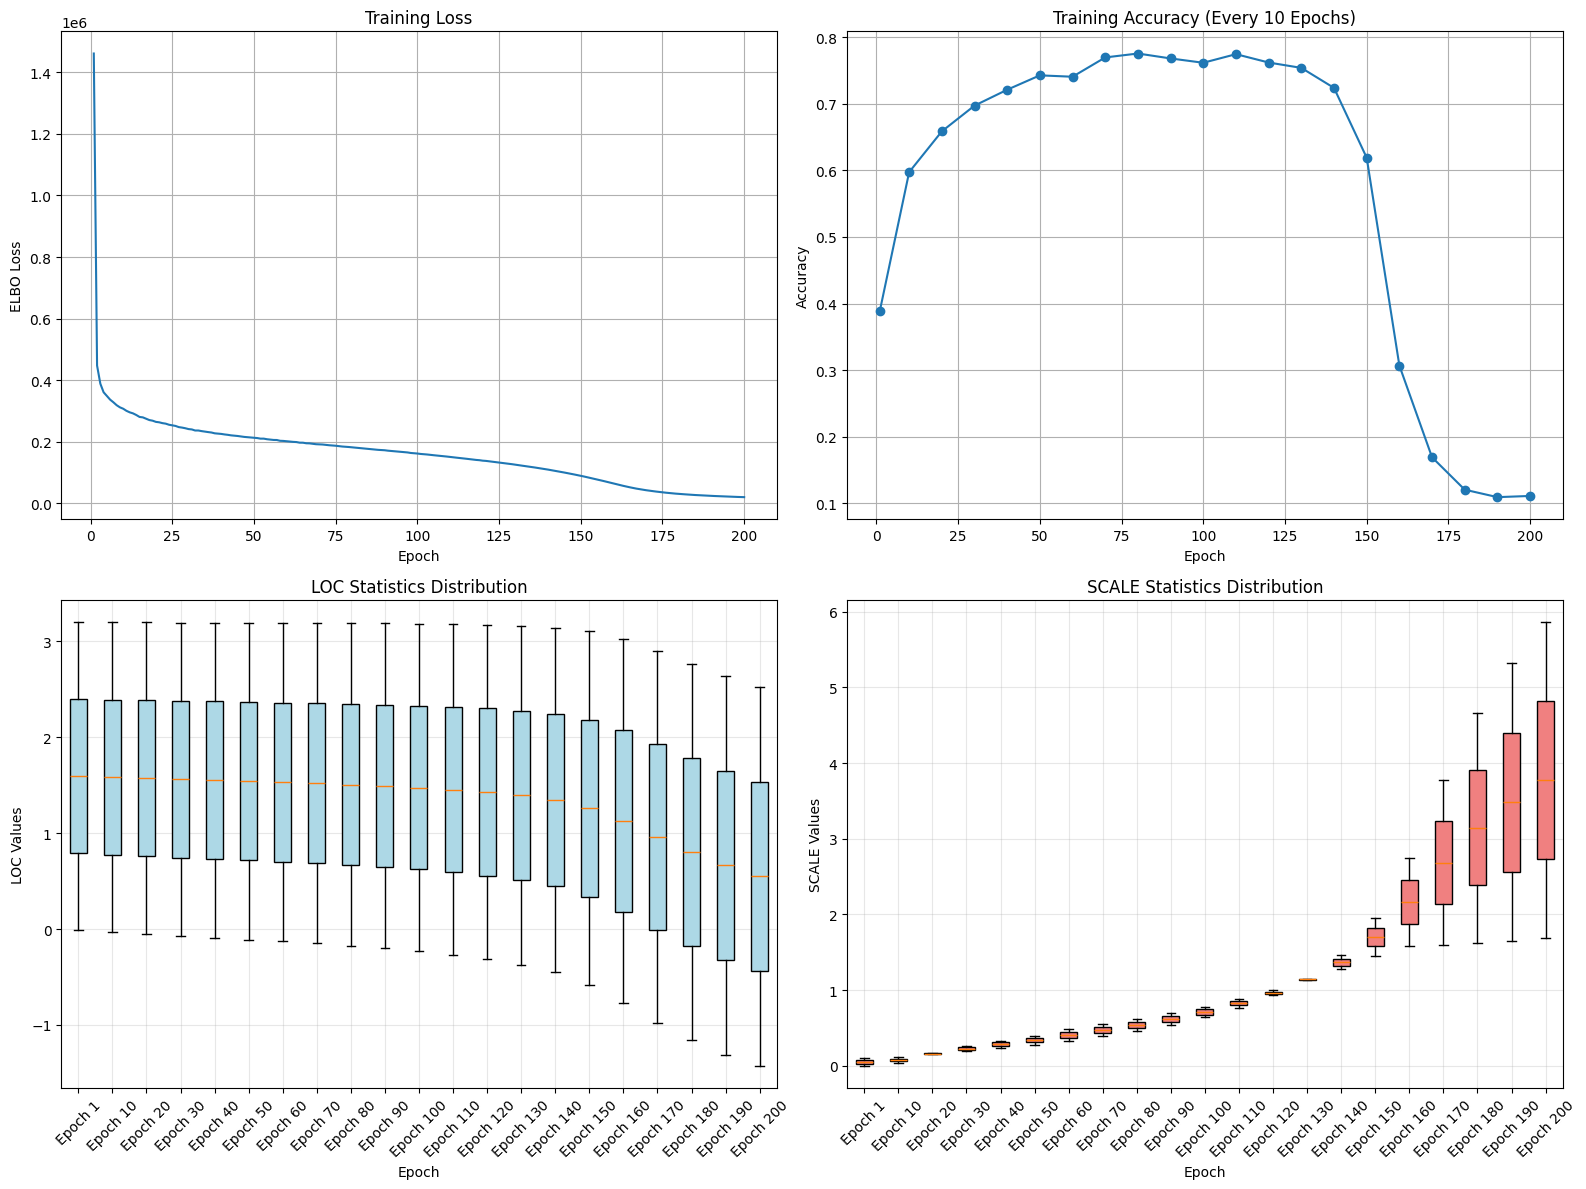

In [14]:
# Plot all results including weight and bias statistics
plot_training_results_with_stats(losses, accuracies, accuracy_epochs, weight_stats, bias_stats)

In [ ]:
#print pyro.get_param_store()
for name, param in pyro.get_param_store().items():
    print(f"{name}: {param.mean().item()} ± {param.std().item()}")  # Print mean and std of each parameter

In [ ]:
weight_stats #turns to df

In [ ]:
bias_stats

In [ ]:
accuracies

In [ ]:
weight_means = []
weight_stds = []
bias_means = []
bias_stds = []

In [ ]:
for name, param in pyro.get_param_store().items():
    print(f"Parameter: {name}, Mean: {param.mean().item()}, Std: {param.std().item()}")
    if 'AutoDiagonalNormal.loc' in name:
        weight_means.append(param.mean().item())
        weight_stds.append(param.std().item())
    elif 'AutoDiagonalNormal.scale' in name:
        bias_means.append(param.mean().item())
        bias_stds.append(param.std().item())

In [ ]:
weight_means

In [ ]:
#pyro.clear_param_store()

# Ensure model and guide are on the correct device
#bayesian_model.to(device)
#guide.to(device)

#train_loader, test_loader = load_data(batch_size=54)
#train_svi(bayesian_model, guide, svi, train_loader, num_epochs=0)

In [15]:
# save the model
model_path = 'results_eurosat/bayesian_cnn_model_std10_200_epoch.pth'
torch.save(bayesian_model.state_dict(), model_path)

# save the guide
guide_path = 'results_eurosat/bayesian_cnn_guide_std10_200_epoch_guide.pth'
torch.save(guide.state_dict(), guide_path)

# save the pyro parameter store
pyro_param_store_path = 'results_eurosat/pyro_param_store_std10_200_epoch.pkl'
pyro.get_param_store().save(pyro_param_store_path)

In [16]:
import numpy as np

In [17]:
# print confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix


def predict_data(model, loader_of_interest, num_samples=10):
    model.eval()
    guide.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(loader_of_interest, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            logits_mc = torch.zeros(num_samples, images.size(0), model.fc1.out_features).to(device)

            for i in range(num_samples):
                guide_trace = pyro.poutine.trace(guide).get_trace(images)
                replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                logits = replayed_model(images)
                logits_mc[i] = logits

            avg_logits = logits_mc.mean(dim=0)
            predictions = torch.argmax(avg_logits, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    return all_labels, all_predictions

In [ ]:
train_labels, train_predictions = predict_data(bayesian_model, train_loader, num_samples=10)

In [ ]:
train_cm = confusion_matrix(train_labels, train_predictions)

In [ ]:
#print accuracy from confusion matrix
train_accuracy = np.trace(train_cm) / np.sum(train_cm)
print(f"Train accuracy from confusion matrix: {train_accuracy * 100:.6f}%")

In [18]:
all_labels, all_predictions = predict_data(bayesian_model, test_loader, num_samples=10)

Evaluating: 100%|██████████| 100/100 [00:04<00:00, 23.38it/s]


In [19]:
cm = confusion_matrix(all_labels, all_predictions)

In [20]:
#print accuracy from confusion matrix
accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy from confusion matrix: {accuracy * 100:.6f}%")

Accuracy from confusion matrix: 11.981481%


In [ ]:
# print pyro parameters
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value.shape} - {value.mean().item():.4f} ± {value.std().item():.4f}")

60.092593% for the 10 epoch

In [ ]:
# plot the confusion matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    # make a mark to the diagonal
    plt.plot([0, cm.shape[1]-1], [0, cm.shape[0]-1], color='red', linestyle='--', linewidth=2)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot the confusion matrix
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
plot_confusion_matrix(cm, class_names)

In [ ]:
# save the model
#model_path = 'results_eurosat/bayesian_cnn_model_std10_100_epoch.pth'
#torch.save(bayesian_model.state_dict(), model_path)

# save the guide
#guide_path = 'results_eurosat/bayesian_cnn_guide_std10_100_epoch_guide.pth'
#torch.save(guide.state_dict(), guide_path)

# save the pyro parameter store
#pyro_param_store_path = 'results_eurosat/pyro_param_store_std10_100_epoch.pkl'
#pyro.get_param_store().save(pyro_param_store_path)

In [ ]:
kataguediemdeh


In [ ]:
def train_svi_early_save(model, guide, svi, train_loader, num_epochs=10, patience=3, min_delta=0.001):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    
    # Lists to store losses and accuracies
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    # Early stopping variables
    best_accuracy = 0.0
    best_epoch = 0
    patience_counter = 0
    best_model_state = None
    best_guide_state = None
    best_pyro_params = None
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            # Check for improvement
            if epoch_accuracy > best_accuracy + min_delta:
                best_accuracy = epoch_accuracy
                best_epoch = epoch + 1
                patience_counter = 0
                
                # Save best model states
                best_model_state = model.state_dict().copy()
                best_guide_state = guide.state_dict().copy()
                best_pyro_params = pyro.get_param_store().get_state().copy()
                
                print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}% *** NEW BEST ***")
            else:
                patience_counter += 1
                print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}% (Best: {best_accuracy*100:.2f}% at epoch {best_epoch})")
                
                # Early stopping check
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered! No improvement for {patience} evaluations.")
                    print(f"Best accuracy: {best_accuracy*100:.2f}% at epoch {best_epoch}")
                    
                    # Restore best model
                    model.load_state_dict(best_model_state)
                    guide.load_state_dict(best_guide_state)
                    pyro.get_param_store().set_state(best_pyro_params)
                    
                    break
            
            model.train()  # Set back to training mode
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    # If training completed without early stopping, still restore best model
    if patience_counter < patience and best_model_state is not None:
        print(f"\nTraining completed. Restoring best model from epoch {best_epoch} (accuracy: {best_accuracy*100:.2f}%)")
        model.load_state_dict(best_model_state)
        guide.load_state_dict(best_guide_state)
        pyro.get_param_store().set_state(best_pyro_params)
    
    return epoch_losses, epoch_accuracies, accuracy_epochs, best_epoch, best_accuracy

In [ ]:
pyro.clear_param_store()

# Ensure model and guide are on the correct device
bayesian_model.to(device)
guide.to(device)

train_loader, test_loader = load_data(batch_size=54)

# Train with early stopping
losses, accuracies, accuracy_epochs, best_epoch, best_accuracy = train_svi(
    bayesian_model, guide, svi, train_loader, 
    num_epochs=100, 
    patience=3,  # Stop if no improvement for 3 accuracy evaluations (30 epochs)
    min_delta=0.001  # Minimum improvement threshold (0.1%)
)

print(f"\nFinal Results:")
print(f"Best training accuracy: {best_accuracy*100:.2f}% at epoch {best_epoch}")

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses) + 1), losses)
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracy_epochs, accuracies, 'o-')
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
plt.axhline(y=best_accuracy, color='red', linestyle=':', alpha=0.7)
plt.title('Training Accuracy (Every 10 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import os

In [ ]:
def train_svi_with_tensorboard(model, guide, svi, train_loader, num_epochs=10, log_dir='runs/bayesian_cnn'):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    
    # Initialize TensorBoard writer
    writer = SummaryWriter(log_dir)
    
    # Lists to store losses and accuracies
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Log loss to TensorBoard every epoch
        writer.add_scalar('Loss/ELBO', avg_loss, epoch + 1)
        
        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            # Log accuracy to TensorBoard
            writer.add_scalar('Accuracy/Train', epoch_accuracy, epoch + 1)
            
            model.train()  # Set back to training mode
            
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    # Close the writer
    writer.close()
    
    return epoch_losses, epoch_accuracies, accuracy_epochs

In [ ]:
# Train with TensorBoard logging
losses, accuracies, accuracy_epochs = train_svi_with_tensorboard(
    bayesian_model, guide, svi, train_loader, 
    num_epochs=100,
    log_dir='runs/eurosat_bayesian_cnn_experiment'
)

In [ ]:
# Train with TensorBoard logging
losses, accuracies, accuracy_epochs = train_svi_with_tensorboard(
    bayesian_model, guide, svi, train_loader, 
    num_epochs=100,
    log_dir='runs/eurosat_bayesian_cnn_experiment'
)

Feature TODO:
1. Record loss after each epoch
2. Send result to GPU